In [4]:
# %pip install altair
# %pip install pandas
# %pip install jupyter
# %pip install matplotlib

In [5]:
import pandas as pd 
import altair as alt
import matplotlib.pyplot as plt
# Ігнорування випливаючих помилок

import warnings 
warnings.filterwarnings('ignore')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [6]:
# Завантаження даних про регіони України
ukraine = alt.topo_feature('https://raw.githubusercontent.com/org-scn-design-studio-community/sdkcommunitymaps/master/geojson/Europe/Ukraine-regions.json', 'UKR_adm1')
# Завантаження даних з про регіони
full_dataset = pd.read_csv('https://raw.githubusercontent.com/kse-ua/KSE-Loc-Data-Hub/main/data-public/derived/full_dataset.csv')
# Створення карти України
ukraine_borders = alt.Chart(ukraine).mark_geoshape(filled=False).properties(width=550, height=400)


Використані файли

In [7]:
# Читання файлів
main_info_buildings = pd.read_csv("buildings1.csv")
price_info = pd.read_csv("50_buildings_prices_monthly_history1.csv")
naming = pd.read_csv("naming - Sheet1.csv")
year_info = pd.read_csv("buildings_queues_monthly_history.csv")

In [8]:
# Фільтрація основного датасету
main_info_buildings = main_info_buildings.drop(columns=["raion","name_uk", "city", "district", "microdistrict", "address_uk", "class"])
main_info_buildings = main_info_buildings[(main_info_buildings["longitude"] != 0) & (main_info_buildings["latitude"] != 0)]
main_info_buildings_filtered = main_info_buildings[(main_info_buildings["region"] != 'вул. Херсонська (Кибальчича), 2') & (main_info_buildings["region"] != "2")]

Функції

In [9]:
# Створення функцій для графічного відображення інформації
def mark_ukr_map(data,color_1,name):
    mark_ukr = alt.Chart(data).mark_square(filled=True, color=color_1).encode(
        latitude='latitude',
        longitude='longitude',
    ).properties(
        title=name
    ).interactive()
    return mark_ukr

def ukraine_map_info(data, col, name, color):
    ukraine_map = alt.Chart(ukraine).mark_geoshape(
        stroke='white'
    ).transform_lookup(
        lookup='properties.NAME_1',
        from_=alt.LookupData(data, 'region_en', [col])
    ).encode(
        tooltip=['properties.NAME_1:N', f'{col}:Q'],
        color=alt.Color(f'{col}:Q', scale=alt.Scale(scheme=color))
    ).properties(
        width=550, 
        height=400,
        title=name
    )
    return ukraine_map

def bar_chart(data,x,y,name):
    chart = alt.Chart(data).mark_bar().encode(
        alt.X(x),
        alt.Y(y, sort='-x')
    ).encode(
        tooltip=[x],
    ).properties(
        width=300, 
        height=400,
        title=name
    )
    
    return chart

Поточна ситуація в розрізі областей та конкретних міст

Загальна статистика об'єктів

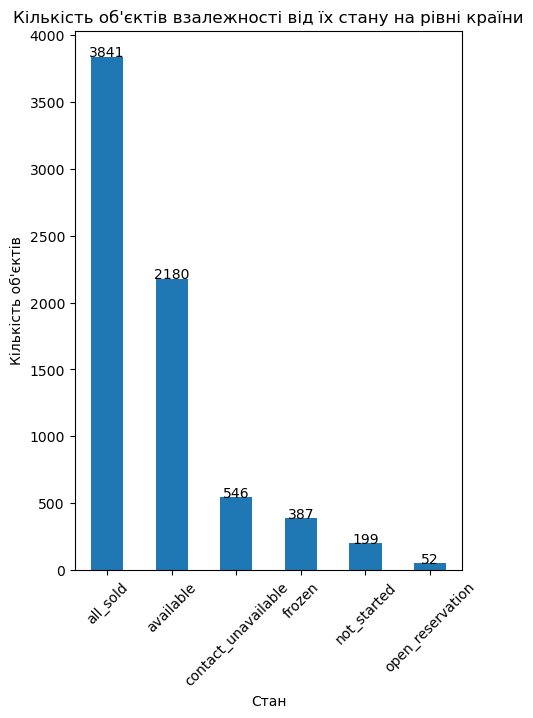

In [10]:
# Підрахунок кількості об'єктів по колонці developer_offer
offer_counts = main_info_buildings_filtered["developer_offer"].value_counts()

# Лісти для відображення графіка
x = offer_counts.index.tolist()
y = offer_counts.tolist()

# Встановлення налаштувань стовпчикової діаграми
plt.figure(figsize=(5, 7))
ax = offer_counts.plot(kind='bar')


plt.xlabel('Стан')
plt.ylabel("Кількість об'єктів")

# Додавання значень до стовпчиків
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha='center')


plt.title("Кількість об'єктів взалежності від їх стану на рівні країни")

# Поворот міток на осі X на 45 градусів для кращої читабельності
plt.xticks(rotation=45)

plt.show()

Отже, бачимо, що кількість проданих об'єктів є найбільшою, зі зрозумілих причин. Трохи нижчою є колонка з готовими до покупки об'єктами, і далі, по спаданню, бачимо будівлі в інших станах.

Загальна статистика об'єктів по регіонах

In [11]:
# Фільтрація даних за категорією developer_offer для кожного стану
all_sold_offer = main_info_buildings_filtered[main_info_buildings_filtered["developer_offer"] == "all_sold"]
available_offer = main_info_buildings_filtered[main_info_buildings_filtered["developer_offer"] == "available"]
not_started_offer = main_info_buildings_filtered[main_info_buildings_filtered["developer_offer"] == "not_started"]
frozen_offer = main_info_buildings_filtered[main_info_buildings_filtered["developer_offer"] == "frozen"]

# Групування даних за регіонами і підрахунок кількості об'єктів
region_all_sold = all_sold_offer.groupby('region').size().reset_index(name='all_sold')
region_available = available_offer.groupby('region').size().reset_index(name='available')
region_not_started = not_started_offer.groupby('region').size().reset_index(name='not_started')
region_frozen = frozen_offer.groupby('region').size().reset_index(name='frozen')

# Злиття обрахованих даних по регіонах у єдиний датафрейм
merged_data = region_all_sold.merge(region_available, on='region', how='outer').merge(region_not_started, on='region', how='outer').merge(region_frozen, on='region', how='outer')

# Злиття датафрейму з naming для візуалізації на мапі України
final_info = merged_data.merge(naming, on='region')


In [12]:
# Створення карти з точковим позначенням об'єктів
all_sold_map = mark_ukr_map(all_sold_offer,'grey',"Точкова мапа проданих об'єктів")
chart1 = (ukraine_borders+all_sold_map)

# Створення карти з інформацією по регіонах
all_sold_ukr = ukraine_map_info(final_info,"all_sold","Мапа проданих об'єктів", "greys")
chart2 = (ukraine_borders+all_sold_ukr)

# Об'єднання двох графіків у один комбінований графік
combined_chart1 = alt.hconcat(chart1, chart2)
combined_chart1

alt.HConcatChart(...)

!Інформація по Києву врахована в обласну (тому він білий)

Досить очікувано, що найбільше проданих споруд у Києві, але наприклад бачимо, що у Львові розпродана забудова є набагато більш розкиданою по області.

In [13]:
# Створення карти з точковим позначенням об'єктів
available_map = mark_ukr_map(available_offer,'green',"Точкова мапа доступних до покупки об'єктів")
chart3 = (ukraine_borders+available_map)

# Створення карти з інформацією по регіонах
available_ukr = ukraine_map_info(final_info,"available","Мапа доступних до покупки об'єктів", "greens")
chart4 = (ukraine_borders+available_ukr)

# Об'єднання двох графіків у один комбінований графік
combined_chart2 = alt.hconcat(chart3, chart4)
combined_chart2

alt.HConcatChart(...)

!Інформація по Києву врахована в обласну (тому він білий)

Досить схожі результати з інформацією з попереднього графіку. Київ все ще лідер, а Львів йде за ним. Цього разу забудова вже більш розкидана по київській області.

In [14]:
# Створення карти з точковим позначенням об'єктів
not_started_map = mark_ukr_map(not_started_offer,'blue',"Точкова мапа об'єктів, будівництво яких ще не розпочалося")
chart5 = (ukraine_borders+not_started_map)

# Створення карти з інформацією по регіонах
not_started_ukr = ukraine_map_info(final_info,"not_started","Мапа об'єктів, будівництво яких ще не розпочалося", "blues")
chart6 = (ukraine_borders+not_started_ukr)

# Об'єднання двох графіків у один комбінований графік
combined_chart3 = alt.hconcat(chart5, chart6)
combined_chart3

alt.HConcatChart(...)

!Інформація по Києву врахована в обласну (тому він білий)

Київ знову лідер, бачимо, що західні регіони у цьому випадку дуже наближені до Льова, який мав високі показникі всі попередні рази.

In [15]:
# Створення карти з точковим позначенням об'єктів
frozen_map = mark_ukr_map(frozen_offer,'red',"Точкова мапа заморожених об'єктів")
chart7 = (ukraine_borders+frozen_map)

# Створення карти з інформацією по регіонах
frozen_ukr = ukraine_map_info(final_info,"frozen","Мапа заморожених об'єктів", "reds")
chart8 = (ukraine_borders+frozen_ukr)

# Об'єднання двох графіків у один комбінований графік
combined_chart4 = alt.hconcat(chart7, chart8)
combined_chart4

alt.HConcatChart(...)

!Інформація по Києву врахована в обласну (тому він білий)

Вже досить очікуваним лідером є Київ, але цього разу Львів не займає другого місця, лідером замість нього стає Харків.

Вартість квадратного метра (середня та максимальна)

In [16]:
# Фільтрація датасету
meter_filtered_price_info = price_info[(price_info["price_per_meter"] != 0) & 
    (price_info["max_price_per_meter"] != 0)]
meter_filtered_price_info = meter_filtered_price_info[(meter_filtered_price_info["min_area"] >= 20) & 
    (meter_filtered_price_info["min_area"] <= 500)]
meter_filtered_price_info = meter_filtered_price_info[(meter_filtered_price_info["max_area"] >= 20)]

In [17]:
# Переведення гривень в долари для уніфікації валюти
ukr_cur_price = meter_filtered_price_info[meter_filtered_price_info["currency"] == "uah"].copy()
ukr_cur_price.loc[:, "price_per_meter"] = ukr_cur_price["price_per_meter"] / 40.42
meter_filtered_price_info.loc[ukr_cur_price.index, "price_per_meter"] = ukr_cur_price["price_per_meter"]


ukr_cur_max_price = meter_filtered_price_info[meter_filtered_price_info["currency"] == "uah"].copy()
ukr_cur_max_price.loc[:, "max_price_per_meter"] = ukr_cur_max_price["max_price_per_meter"] / 40.42
meter_filtered_price_info.loc[ukr_cur_max_price.index, "max_price_per_meter"] = ukr_cur_max_price["max_price_per_meter"]

In [18]:
# Обчислення середньої ціни за квадратний метр
average_price_per_meter = meter_filtered_price_info.groupby('building_id')[['price_per_meter', 'max_price_per_meter']].mean().reset_index()

# Злиття середньої ціни з основною інформацією про будівлі
merged_price_info = average_price_per_meter.merge(main_info_buildings_filtered, on='building_id')

# Обчислення середньої ціни за квадратний метр для кожного регіону окремо
average_price_per_region = merged_price_info.groupby('region')[['price_per_meter', 'max_price_per_meter']].mean().reset_index()

# Злиття датафрейму з naming для візуалізації на мапі України
en_naming_price_info = average_price_per_region.merge(naming, on='region')


In [19]:
# Створення стовпчикової діаграми для середньої вартості квадратного метра за регіонами
chart9 = bar_chart(en_naming_price_info,'price_per_meter','region',"Зміна середньої вартості квадратного метра в $")

# Створення карти зміни середньої вартості квадратного метра за регіонами
av_price_info = ukraine_map_info(en_naming_price_info,"price_per_meter","Карта зміни середньої вартості квадратного метра в $", "greens")
chart10 = (ukraine_borders+av_price_info)

combined_chart5 = alt.hconcat(chart9, chart10)
combined_chart5

alt.HConcatChart(...)

Лідером, неочікувано для мене стає закарпатська область, ймовірно через геоположення та гори навколо. Знову ж таки попри очікування Київ не посідає друге місце по ціні, його має Львів, Київ - третій. Можемо прослідкувати тенденцію, що західні регіони всередньому мають вищі ціни за квадратний метр.

In [20]:
# Створення стовпчикової діаграми для максимальної вартості квадратного метра за регіонами
chart11 = bar_chart(en_naming_price_info,'max_price_per_meter','region',"Зміна максимальної вартості квадратного метра в $")

# Створення карти зміни максимальної вартості квадратного метра за регіонами
mx_price_info = ukraine_map_info(en_naming_price_info,"max_price_per_meter","Карта зміни максимальної вартості квадратного метра", "oranges")
chart12 = (ukraine_borders+mx_price_info)

combined_chart6 = alt.hconcat(chart11, chart12)
combined_chart6

alt.HConcatChart(...)

Ситуація досить схожа з попередньою, але за максимальною вартістю квадратного метра Київ знаходиться вище за Львів.

Активність на ринку первинної нерухомості по регіонах

Кількість збудованого житла у різних областях за певні роки

In [21]:
#Видаляю дублікати, щоб отримати інормацію про будинки без дублікатів 
year_info_filtered = year_info.drop_duplicates(subset="building_id")

In [22]:
# Злиття інформації про рік завершення будівництва з основною інформацією про будівлі
year_of_end_info = year_info_filtered.merge(main_info_buildings_filtered, on="building_id")

# Фільтрація об'єктів, які вже побудовані
year_of_built = year_of_end_info[year_of_end_info['state_x']=="built"]

# Групування за регіоном та роком завершення будівництва
grouped_year_of_built = year_of_built.groupby(['region', 'year_of_end']).size().reset_index(name='count')
grouped_year_of_built_filtered = grouped_year_of_built[grouped_year_of_built["year_of_end"] <= 2024]

In [23]:
alt.Chart(grouped_year_of_built_filtered).mark_circle().encode(
    x='region:O',
    y='year_of_end:O',
    size='sum(count):Q',
    tooltip=['year_of_end:O','count:Q'],
).properties(
        title="Кількість закінчених об'єктів по областях та роках"
    )

alt.Chart(...)

Графік досить специфічний, але, як на мене, коли ти знаєш яка саме область тебе цікавить, інформація стає дуже доступною. Бачимо, що наприклад у Києві 2014 року було закінчено будівель найбільше за всі роки, у Львові такий бум відбувся в 2021.

Стан об'єктів в різні періоди

In [24]:
merged1 = year_info.merge(main_info_buildings_filtered, on="building_id")
# Групуємо об'єднаний датафрейм за month і рахуємо кількість по developer_offer_x
merged1_gruped = merged1.groupby(['month'])['developer_offer_x'].value_counts().reset_index()

main_merged1_gruped = merged1_gruped[merged1_gruped['developer_offer_x']=="all_sold"]

chart = alt.Chart(merged1_gruped).mark_bar(
    cornerRadiusTopLeft=3,
    cornerRadiusTopRight=3
).encode(
    x=alt.X('count:Q', title='Developer Offer Count'),
    y=alt.Y('month:O', title='Month'),
    color=alt.Color('developer_offer_x:N', title='Developer Offer'),
    tooltip=['count:Q']
).properties(
    width=600,
    height=400,
    title='Developer Offers per Month',
)
# Додаю мітки для пропозицій "all_sold", для крашого розуміння на презентації
text = alt.Chart(main_merged1_gruped).mark_text(dx=-30, dy=1, color='white').encode(
    x=alt.X('count:Q'),
    y=alt.Y('month:O'),
    text=alt.Text('count:Q', format='.1f')
)

(chart + text)

alt.LayerChart(...)

Бачимо, що всі типи забудови мають зростаючу тендецію від місяця до місяця.

Зміни у цінах на нерухомість за останній місяць, а також зміну “розпроданості” обʼєктів

Кількість обʼєктів різного стану за місяці

In [25]:
merged = price_info.merge(main_info_buildings_filtered, on="building_id")
# Фільтруємо по is_sold дорівнює no, бо мене цікавлять тількі непродані об'єкти
merged = merged[merged["is_sold"]=="no"]
merged = merged[merged["developer_offer"]!='all_sold']
merged_info = merged.groupby(['month'])['developer_offer'].value_counts().reset_index()
# Фільтруємо дані, залишаючи лише 2024-04-24 та 2024-05-24
filtered_info = merged_info[merged_info["month"].isin(["2024-04-24", "2024-05-24"])]

# Обираємо тільки available обʼєкти
info_available = filtered_info[filtered_info["developer_offer"]=="available"]

# Додатково дивимося на всі окрім available
info2 = filtered_info[filtered_info["developer_offer"]!="available"]


In [26]:
chart = alt.Chart(info_available).mark_bar().encode(
    x=alt.X('month:N', title='Month'),
    y=alt.Y('count:Q', title='Count'),
    color=alt.Color('developer_offer:N', title='Developer Offer'),
    column=alt.Column('developer_offer:O', title='Developer Offer'),
    tooltip='count:Q'
).properties(
    width=150,
    title='Розпроданість обʼєктів за місяці'
)
chart

alt.Chart(...)

Кількість вільних квартир, попри мої очікування зріс. Ймовірно це через здачу нових обʼєктів.

In [27]:
chart = alt.Chart(info2).mark_bar().encode(
    x=alt.X('month:N', title='Month'),
    y=alt.Y('count:Q', title='Count'),
    color=alt.Color('developer_offer:N', title='Developer Offer'),
    column=alt.Column('developer_offer:O', title='Developer Offer'),
    tooltip='count:Q'
).properties(
    width=150,
    title='Кількість обʼєктів різного стану за місяці'
)
chart

alt.Chart(...)

Тенденція до росту чи спаду майже відсутня, не початі обʼєкти мають зріст на одиницю, відносно цього обʼєкти з відкритою резервацією зросли значно.

Зміни у цінах на нерухомість

In [28]:
info = main_info_buildings_filtered.merge(price_info, on="building_id")

# Замінюємо значення в колонці 'is_sold' на булеві
info['is_sold'] = info['is_sold'].map({'yes': True, 'no': False})
# Групуємо дані, рахуємо кількість проданих і непроданих об'єктів, записуємо в нові колонки
grouped_info = info.groupby(['region', 'month'])['is_sold'].value_counts().unstack(fill_value=0)
grouped_info.columns = ['unsold_count', 'sold_count']

# Обчислюємо відсоткову зміну кількості проданих об'єктів для кожного регіону
grouped_info["unsold_prc"] = grouped_info.groupby('region')['unsold_count'].pct_change() * 100
grouped_info["unsold_prc"] = grouped_info['unsold_prc'].fillna(0)
grouped_info["sold_prc"] = grouped_info.groupby('region')['sold_count'].pct_change() * 100
grouped_info["sold_prc"] = grouped_info['sold_prc'].fillna(0)

grouped_info = grouped_info.reset_index()

In [29]:
merged_df = meter_filtered_price_info.merge(main_info_buildings_filtered, on = "building_id")

grouped = merged_df.groupby(['region', 'month'])

# Обчислюємо середню ціну за квадратний метр для кожної групи
average_prices = grouped['price_per_meter'].mean().reset_index()
# Обчислюємо відсоткову зміну середньої ціни за квадратний метр для кожного регіону
average_prices['pct_change'] = average_prices.groupby('region')['price_per_meter'].pct_change() * 100
# Заповнюємо відсутні значення нулями
average_prices['pct_change'] = average_prices['pct_change'].fillna(0)

In [30]:
# Залишаємо лише дані за другий місяць
second_month_price = average_prices[average_prices["month"] == "2024-04-24"].merge(naming, on='region')

In [31]:
chart13 = bar_chart(second_month_price,"pct_change","region","name")

second_map = ukraine_map_info(second_month_price,"pct_change","Зміна вартості квадратного метра з 03-24 до 04-24", "lightgreyred")
chart14 = (ukraine_borders+second_map)

combined_chart7 = alt.hconcat(chart13, chart14)
combined_chart7

alt.HConcatChart(...)

Бачимо, що майже половина областей має спад вартості квадратного метра, відповідно до зміни місяця. Запорізька область має найбільший спад вартості, а Закарпатська найбільший підйом (у цьому випадку можемо це списати на відносну безпеку в період війни). Кіровоград зміни у вартості немає.

In [32]:
# Залишаємо лише дані за третій місяць
third_month_price = average_prices[average_prices["month"] == "2024-05-24"].merge(naming, on='region')

In [33]:
chart15 = bar_chart(third_month_price,"pct_change","region","name")

third_map = ukraine_map_info(third_month_price,"pct_change","Зміна вартості квадратного метра з 04-24 до 05-24", "lightgreyred")
chart16 = (ukraine_borders+third_map)

combined_chart8 = alt.hconcat(chart15, chart16)
combined_chart8

alt.HConcatChart(...)

Можливо ці дані не є обʼєктивними до кінця через неповний 5 місяць. Але уже можемо прослідкувати, що Івано-Франківська область має найбільший зріс. Серед найбільших міст ситуація досить стабільна.

Ось таке дослідження у мене вийшло. Дякую!